# Analysis of Corporate Lobbying

<p>
This notebook will contain analysis of the master_df scraped and updated <br>
from corporate_lobbying.ipynb and update_master.ipynb.
<br><br>
This will be a slow burn - my data goes back to Aug 5 2025 and the website which I am <br>
scraping from gets updated daily.
<br><br>
I want to gather data slowly and over time see how the amount of corporate lobbying affects <br>
the stock price of the companies conducting the lobbying.
</p>

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

In [7]:
df = pd.read_csv(r'C:\Users\ronan\Projects\master_df.csv', parse_dates=['Date'], dayfirst=True)

In [8]:
df.head(50)

,Ticker,Company Name,Amount,Date
0,RVTY,Revvity Inc.,30000,2025-10-02
1,NKE,Acg Advocacy On Behalf Of Nike Inc.,10000,2025-10-02
2,JNJ,Johnson & Johnson,30000,2025-10-02
3,FOLD,Amicus Therapeutics Inc.,10000,2025-10-02
4,ML,Gen Digital Inc (Formerly Reported As Moneylio...,60000,2025-10-02
5,LMT,Lockheed Martin Aeronautic Sector,31415,2025-10-02
6,TBBK,Zions Bancorp,52500,2025-10-02
7,DOC,Healthpeak Properties Inc. Fka Physicians Real...,60000,2025-10-02
8,TRMB,Trimble Inc.,30000,2025-10-02
9,KR,The Kroger Co.,70000,2025-10-02


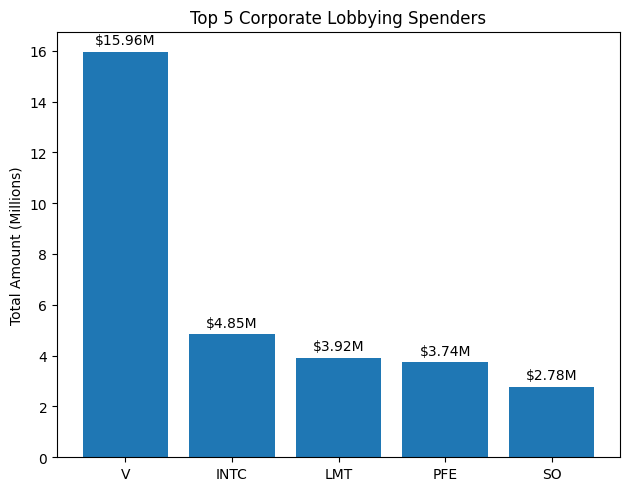

In [11]:
totals = df.groupby('Ticker')['Amount'].sum().sort_values(ascending=False).head()

fig, ax = plt.subplots()
bars = ax.bar(totals.index, totals.values / 1_000_000)
ax.set_ylabel("Total Amount (Millions)")

ax.bar_label(bars,
             labels=[f"${v/1_000_000:.2f}M" for v in totals.values],
             padding=3)
plt.tight_layout()
plt.title('Top 5 Corporate Lobbying Spenders')
plt.show()

In [14]:
df.groupby('Ticker')['Amount'].sum().sort_values(ascending=False).head(10)

Ticker
V       15960000
INTC     4850000
LMT      3890000
PFE      3740000
SO       2780000
TAK      1570000
ARDX     1280000
CTVA      900000
FLR       855887
BAH       650000
Name: Amount, dtype: int64

<p>
Recently the ticker V (Visa) jumped head of INTC as the company who has lobbied the most since I started recording data <br>
I want to look more into this because they spent almost $16m on lobbying
</p>

In [22]:
df[df['Ticker'] == 'V']

,Ticker,Company Name,Amount,Date
59,V,Visa Inc.,2040000,2025-09-26
60,V,Visa Inc.,1800000,2025-09-26
61,V,Visa Inc.,1810000,2025-09-26
62,V,Visa Inc.,2030000,2025-09-26
63,V,Visa Inc.,1420000,2025-09-26
64,V,Visa Inc.,2440000,2025-09-26
65,V,Visa Inc.,2310000,2025-09-26
66,V,Visa Inc.,2110000,2025-09-26


<p>
Holy shit - they spent $16m dollars in one day on lobbying - lets see how their stock has since reacted to see if there has been a<br>
significant reaction
</p>

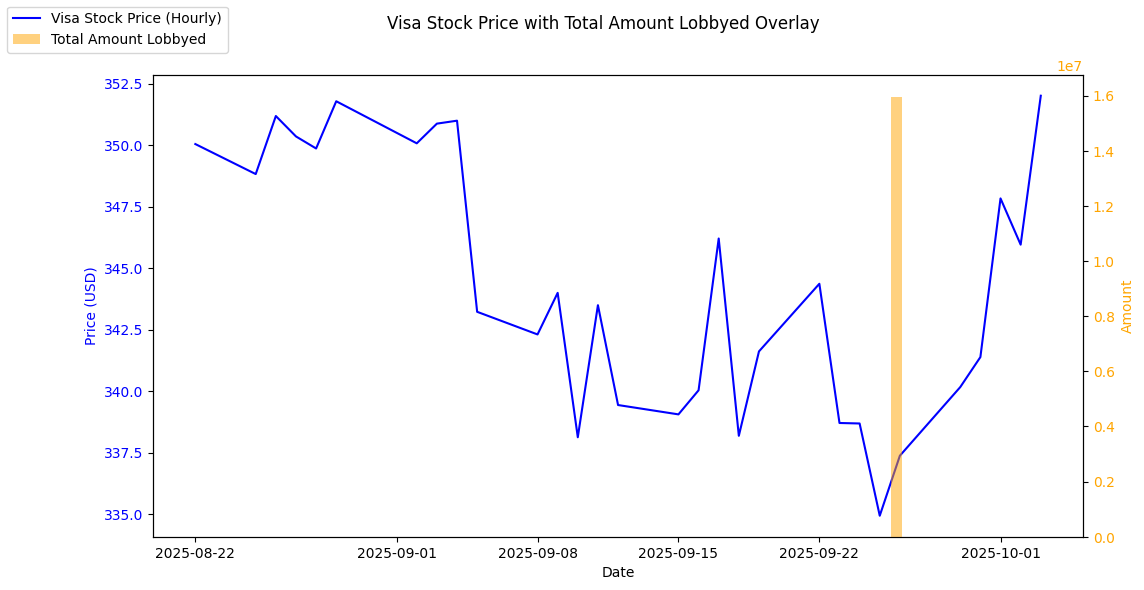

In [28]:
import matplotlib.pyplot as plt
import yfinance as yf

# Example stock data
ticker = yf.Ticker("V")
price_data = ticker.history(period="30d", interval="1d")

# --- Convert Date column to datetime ---
df['Date'] = pd.to_datetime(df['Date'])

# Filter Visa
visa_df = df[df['Ticker'] == 'V']

# Compute total Amount
total_amount = visa_df['Amount'].sum()

# Pick a date to position the bar (e.g., the last date in your stock data)
bar_date = pd.to_datetime("2025-09-26")

# --- Plot ---
fig, ax1 = plt.subplots(figsize=(12,6))

# Stock price
ax1.plot(price_data.index, price_data["Close"], label="Visa Stock Price (Hourly)", color="blue")
ax1.set_xlabel("Date")
ax1.set_ylabel("Price (USD)", color="blue")
ax1.tick_params(axis="y", labelcolor="blue")

# Amount bar on secondary y-axis
ax2 = ax1.twinx()
ax2.bar(bar_date, total_amount, width=0.5, color="orange", alpha=0.5, label="Total Amount Lobbyed")
ax2.set_ylabel("Amount", color="orange")
ax2.tick_params(axis="y", labelcolor="orange")

# Title and legends
fig.suptitle("Visa Stock Price with Total Amount Lobbyed Overlay")
fig.legend(loc="upper left")

plt.show()